# CHE1148 Assignment 4

#### YANBIN ZHANG 1008879732

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### Import monthly features data and filter into two sets

In [2]:
monthly_features = pd.read_csv('mth_features_outputs.csv')

In [3]:
monthly_features = monthly_features.sort_values(by=['ME_DT'])
monthly_features = monthly_features.reset_index(drop=True)
train = monthly_features.loc[monthly_features.ME_DT<'2014-01-31']
test = monthly_features.loc[monthly_features.ME_DT>='2014-01-31']

In [4]:
x_train = train.drop(['response'], axis = 1)
y_train = train['response']
X_train = x_train.drop(['CLNT_NO','ME_DT'],axis=1)
colnames = X_train.columns
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

In [5]:
X_test = test.drop(['CLNT_NO','response'], axis = 1)
y_test = test['response']

### Fit random forest model and find top 5 features

In [6]:
rf = RandomForestClassifier(n_estimators = 200, max_features="sqrt", max_depth=20, 
                            min_samples_split = 20, random_state=1148)
rf.fit(X_train_std, y_train)
importances = rf.feature_importances_

In [7]:
impor = pd.DataFrame(importances, index=colnames, columns=['Feature Importance'])
impor = impor.sort_values(by=['Feature Importance'], ascending=False)
top_5_features = impor.index[0:5]
top_5_features

Index(['days_since_last_txn', 'amt_max_12M', 'amt_mean_12M', 'amt_sum_12M',
       'amt_max_6M'],
      dtype='object')

### Compute baseline score and clients scores after Jan-2014, then compute monthly JS divergence

In [8]:
baseline_score = rf.predict_proba(X_train_std)[:,1]
bin_edges = np.quantile(baseline_score, np.arange(0, 1.1, 0.1))
bin_edges[0]=0
p = np.histogram(baseline_score, bin_edges)

In [9]:
month = X_test['ME_DT'].unique()
JS_monthly = []
for i in range(len(month)):
    test_set = X_test.loc[X_test['ME_DT']==month[i]]
    test_set = test_set.drop(['ME_DT'],axis=1)
    test_set_std = scaler.transform(test_set)
    predict_test = rf.predict_proba(test_set_std)[:,1]
    q = np.histogram(predict_test,bin_edges)
    JS_monthly.append(distance.jensenshannon(p[0],q[0],2.0))

### Compute Jensen-Shannon divergence metric for the top 5 features

In [10]:
JS_feature = pd.DataFrame(index=top_5_features,columns=np.arange(0,15))
bin_edge = np.r_[-np.inf, bin_edges , np.inf]
for i in range(len(month)):
    for j in range(len(top_5_features)):
        test_set = X_test.loc[X_test['ME_DT']==month[i]][top_5_features[j]]
        baseline_set = X_train[top_5_features[j]]
        target_score = test_set/test_set.max()
        baseline_score= baseline_set/baseline_set.max()
        p = np.histogram(baseline_score, bin_edge)
        q = np.histogram(target_score, bin_edge)
        JS_feature.at[top_5_features[j],i] = distance.jensenshannon(p[0], q[0], 2.0)

### Plot the monthly JS divergence with time

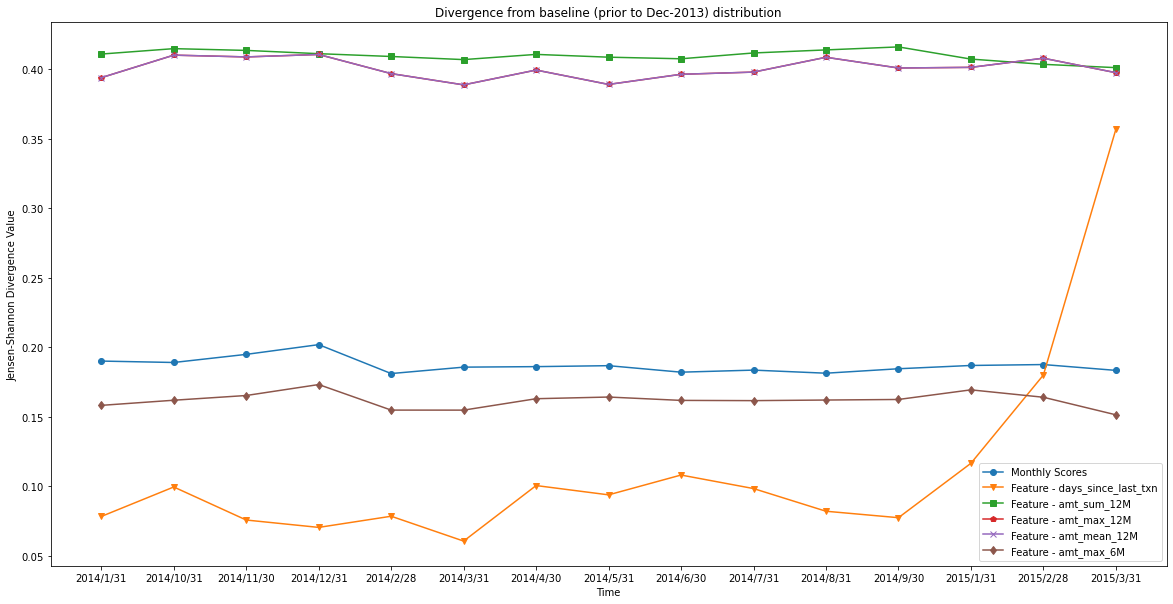

In [11]:
plt.figure(figsize=(20,10))
plt.plot(month, JS_monthly, '-o', label = 'Monthly Scores')
plt.plot(month, JS_feature.iloc[0,:], '-v', label = 'Feature - days_since_last_txn')
plt.plot(month, JS_feature.iloc[1,:], '-s', label = 'Feature - amt_sum_12M')
plt.plot(month, JS_feature.iloc[2,:], '-p', label = 'Feature - amt_max_12M')
plt.plot(month, JS_feature.iloc[3,:], '-x', label = 'Feature - amt_mean_12M')
plt.plot(month, JS_feature.iloc[4,:], '-d', label = 'Feature - amt_max_6M')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Jensen-Shannon Divergence Value')
plt.title('Divergence from baseline (prior to Dec-2013) distribution')
plt.show()

We used the random forest model with specific parameters to determine the top five features with the highest feature importance, namely 'days_since_last_txn', 'amt_sum_12M', 'amt_max_12M', 'amt_mean_12M', and 'amt_max_6M'. We then calculated the monthly clients scores based on the probability of response = 1.

Upon analyzing the Jensen-Shannon Divergence value graph, we observed that the monthly Jensen-Shannon Divergence values were generally around 0.2 or less. This indicates that the distribution of the baseline and data after Jan-14 differed slightly, but not significantly, as the Jensen-Shannon Divergence values were around 0.2.

Regarding the feature "days_since_last_txn", we noticed that the Jensen-Shannon Divergence values were above 0.2 and sharply increased to almost 0.4 in the last three months. Therefore, we can conclude that the distributions for this feature were markedly different.

For the features "amt_sum_12M" and "amt_mean_12M", their Jensen-Shannon Divergence value lines overlapped, indicating identical distributions. Their values were greater than 0.2 and very close to 0.4, suggesting significant differences in their distributions.

The feature "amt_max_12M" had the highest Jensen-Shannon Divergence values among all features, significantly different from the level of Jensen-Shannon Divergence value = 0.2.

Lastly, the Jensen-Shannon Divergence values for the "amt_max_6M" feature were the lowest, around 0.15, indicating only slight differences in the distributions of this feature.